In [15]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from libra_toolbox.tritium.model import (
    quantity_to_activity,
    activity_to_quantity,
)
from libra_toolbox.tritium.plotting import (
    ureg,
    plot_bars,
    plot_integrated_top_release,
    plot_integrated_wall_release,
    plot_irradiation,
    plot_sample_activity_top,
    plot_sample_activity_wall,
    plot_salt_inventory,
    plot_top_release,
    plot_wall_release,
)

ureg.mpl_formatter = "{:~P}"
# remove top and right axes by default
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# set axis below true by default
plt.rcParams["axes.axisbelow"] = True

from tritium_model import *

Quantity of T consumed: 4.09×10¹² particle
Uncertainty on T consumed: 4.09×10¹¹ particle
Quantity of T consumed: 7.31×10³ Bq
Quantity of T produced: 2.96×10¹ Bq
Quantity of T produced: 1.65×10¹⁰ particle
Measured TBR: 4.04e-03 particle / neutron
0.5048832020864873 dimensionless


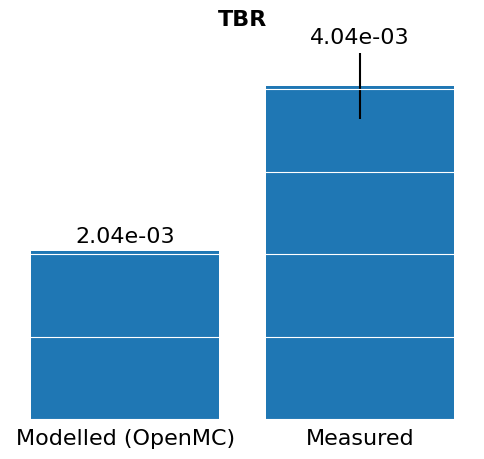

In [16]:
print(f"Quantity of T consumed: {T_consumed.to(ureg.particle):.2e~P}")
print(
    f"Uncertainty on T consumed: {(neutron_rate_relative_uncertainty * T_consumed).to(ureg.particle):.2e~P}"
)
print(f"Quantity of T consumed: {quantity_to_activity(T_consumed).to(ureg.Bq):.2e~P}")
print(f"Quantity of T produced: {T_produced:.2e~P}")
print(
    f"Quantity of T produced: {activity_to_quantity(T_produced).to(ureg.particle):.2e~P}"
)
print(f"Measured TBR: {measured_TBR:.2e}")
plt.figure(figsize=(6, 5))
bars = plt.bar(
    [0, 1],
    [calculated_TBR, measured_TBR],
    tick_label=["Modelled (OpenMC)", "Measured"],
    yerr=[0, neutron_rate_relative_uncertainty * measured_TBR],
)

plt.bar_label(bars, fontsize=16, fmt="%.2e", padding=3)
plt.title("TBR", weight="bold", fontsize=16)
plt.ylabel("")
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels
plt.gca().tick_params(axis="both", which="both", left=False, bottom=False, labelsize=16)
plt.gca().set_axisbelow(False)
plt.grid(axis="y", alpha=1, color="white", zorder=-10)
# plt.tight_layout()
print((calculated_TBR / measured_TBR).to(ureg.dimensionless))
plt.savefig("tbr_comparison.pdf", bbox_inches="tight")
plt.show()

In [17]:
baby_model.run(50 * ureg.day)

/home/codespace/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)
/opt/conda/envs/baby-1l-run-3/lib/python3.12/site-packages/libra_toolbox/tritium/model.py:162: SyntaxWarning: invalid escape sequence '\m'
  Q_\mathrm{wall} = A_\mathrm{wall} \ k_\mathrm{wall} \ c_\mathrm{salt}
/opt/conda/envs/baby-1l-run-3/lib/python3.12/site-packages/libra_toolbox/tritium/model.py:178: SyntaxWarning: invalid escape sequence '\m'
  Q_\mathrm{top} = A_\mathrm{top} \ k_\mathrm{top} \ c_\mathrm{salt}


AttributeError: Neither Quantity object nor its magnitude ([0.00000000e+00 3.38138138e+01 6.76276276e+01 ... 4.31143868e+06
 4.31571934e+06 4.32000000e+06]) has attribute 'append'

In [ ]:
print(f"Transport:")
print(f"  mass transport coeff top: {baby_model.k_top:.2e~P}")
print(f"  mass transport coeff wall: {baby_model.k_wall:.2e~P}")

print("Source:")
print(f"  TBR: {baby_model.TBR:.2e~P}")
print(f"  neutron rate: {baby_model.neutron_rate:.2e~P}")
print(f"  neutron rate * TBR: {baby_model.neutron_rate * baby_model.TBR:.2e~P}")
# print(f"  k_top/k_wall: {baby_model.k_top/baby_model.k_wall:.2f~P}")

print("Geometry:")
print(f"  volume: {baby_model.volume.to(ureg.cm**3):.2f~P}")
print(f"  top area: {baby_model.A_top.to(ureg.cm**2):.2f~P}")
print(f"  wall area: {baby_model.A_wall.to(ureg.cm**2):.2f~P}")

Transport:
  mass transport coeff top: 1.29×10⁻⁷ m/s
  mass transport coeff wall: 0.00×10⁰ m/s
Source:
  TBR: 2.04×10⁻³ particle/n
  neutron rate: 1.04×10⁸ n/s
  neutron rate * TBR: 2.13×10⁵ particle/s
Geometry:
  volume: 1000.00 cm³
  top area: 153.94 cm²
  wall area: 445.87 cm²


27.01126682237793 day


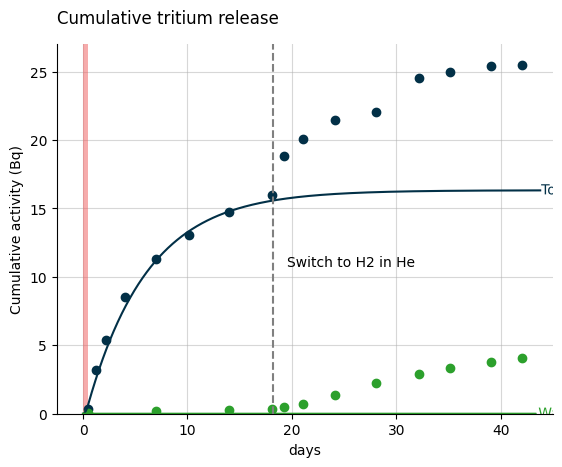

In [ ]:
plt.figure()
(l,) = plot_integrated_top_release(baby_model, color="#023047", label="Top")
plot_integrated_wall_release(baby_model, color="tab:green", label="Wall")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.grid(alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[45] * 2)
plt.ylim(bottom=0 * ureg.Bq)

plt.scatter(
    replacement_times_top, IV_stream.get_cumulative_activity("total"), color="#023047"
)
plt.scatter(
    replacement_times_walls,
    OV_stream.get_cumulative_activity("total"),
    color="tab:green",
)

# add line where top is 99% of final
ydata = l.get_ydata()
xdata = l.get_xdata()
target_release_frac = 0.99
x_target = xdata[np.argmax(ydata > target_release_frac * ydata[-1])]
print(f'{x_target}')
# plt.axvline(x=x_target, color="k", linestyle="--")
plt.axvline(x=gas_switch_deltatime, color="grey", linestyle="--")
#plt.annotate(
#    f"99% of steady state \n {x_target: .0f}",
#    (x_target, target_release_frac * ydata[-1]),
#    xytext=(0, 20),
#    textcoords="offset points",
#    ha="center",
#    va="bottom",
#    color="k",
#)
plt.annotate(
    f"Switch to H2 in He",
    (x_target, target_release_frac * ydata[-1]),
    xytext=(-10, -55),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="black",
)

plt.title("Cumulative tritium release", loc="left", pad = 15)
plt.ylim(top=27)
plt.xlim(right = 45)
plt.xlabel("days")
plt.ylabel("Cumulative activity (Bq)")

plt.savefig("cumulative_release.pdf", bbox_inches="tight")

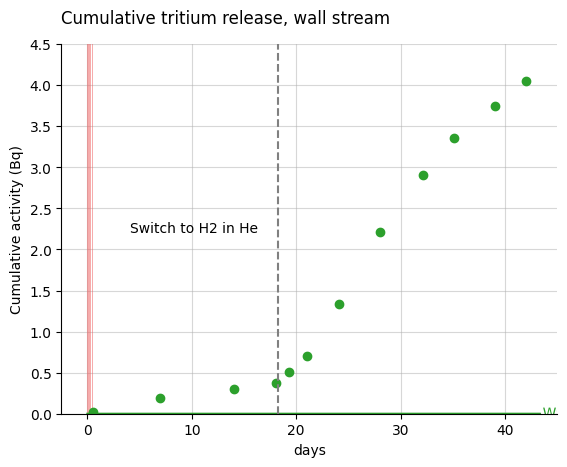

In [ ]:
plt.figure()
plot_integrated_wall_release(baby_model, color="tab:green", label="Wall")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.grid(alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[45]*2)
plt.ylim(bottom=0 * ureg.Bq)

plt.scatter(
    replacement_times_walls,
    OV_stream.get_cumulative_activity("total"),
    color="tab:green",
)

plt.axvline(x=gas_switch_deltatime, color="grey", linestyle="--")
plt.annotate(
    f"Switch to H2 in He",
    (gas_switch_deltatime, 2.0),
    xytext=(-60, 10),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="black",
)

plt.title("Cumulative tritium release, wall stream", loc="left", pad = 15)
plt.ylim(top=4.5)
plt.xlim(right = 45)
plt.xlabel("days")
plt.ylabel("Cumulative activity (Bq)")

plt.savefig("cumulative_release.pdf", bbox_inches="tight")

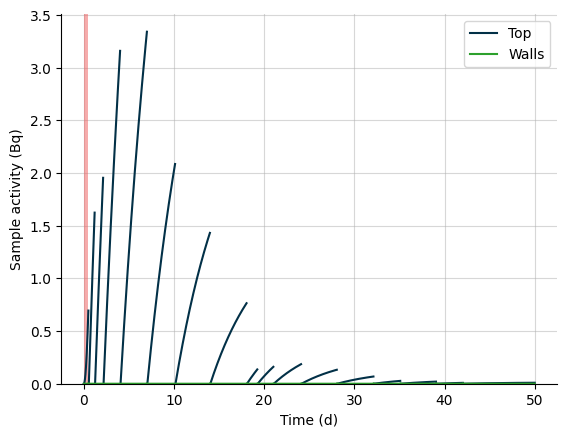

In [ ]:
plot_sample_activity_top(
    baby_model, replacement_times=replacement_times_top, color="#023047", label="Top"
)
plot_sample_activity_wall(
    baby_model,
    replacement_times=replacement_times_walls,
    color="tab:green",
    label="Walls",
)
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.ylim(bottom=0 * ureg.Bq)

plt.ylabel(f"Sample activity ({plt.gca().yaxis.get_units():~P})")
plt.xlabel(f"Time ({plt.gca().xaxis.get_units():~P})")
plt.legend()
plt.grid(alpha=0.5)

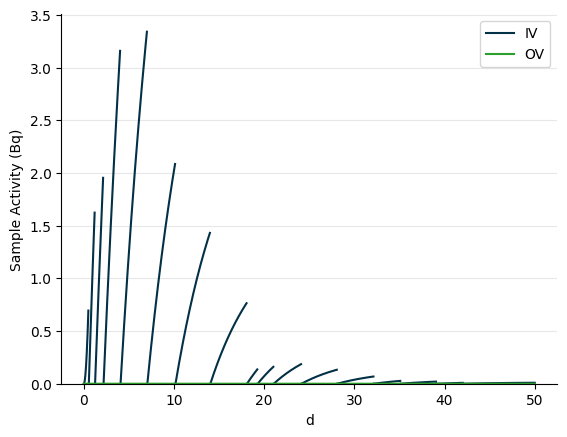

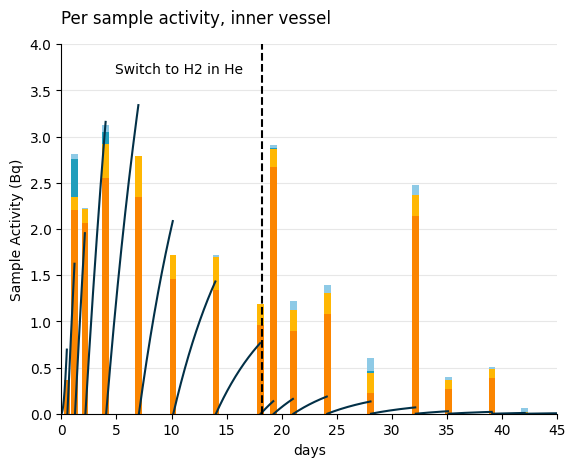

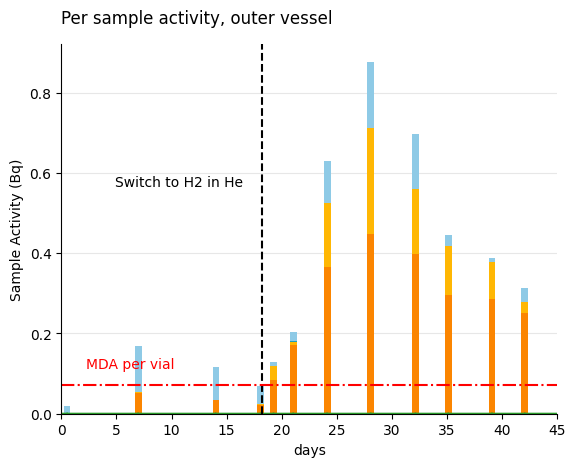

In [ ]:
plt.figure()
plot_sample_activity_top(
    baby_model, replacement_times=replacement_times_top, color="#023047", label="IV"
)
plot_sample_activity_wall(
    baby_model, replacement_times=replacement_times_walls, color="tab:green", label="OV"
)
plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
plt.ylabel("Sample Activity (Bq)")
plt.legend()

plt.figure()
plot_bars(IV_stream, index=[time.to(ureg.day) for time in replacement_times_top], bar_width = 0.6)
plot_sample_activity_top(baby_model, replacement_times=replacement_times_top, color="#023047", label="Model")

plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
plt.xlim(0, 45)
plt.ylim(top=4)
plt.ylabel("Sample Activity (Bq)")
plt.xlabel("days")
plt.title("Per sample activity, inner vessel", loc = 'left', pad = 15)

plt.axvline(x=gas_switch_deltatime, color="k", linestyle="--")
plt.annotate(
    f"Switch to H2 in He",
    (gas_switch_deltatime, 3.5),
    xytext=(-60, 10),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="k",
)

plt.figure()
plot_bars(OV_stream, index=[time.to(ureg.day) for time in replacement_times_walls], bar_width = 0.6)
plot_sample_activity_wall(baby_model, replacement_times=replacement_times_walls, color="tab:green", label="Model")

plt.grid(True, axis="y", alpha=0.3)
# plt.ylim(bottom=0 * ureg.Bq)
plt.xlim(0, 45)
plt.ylabel("Sample Activity (Bq)")
plt.xlabel("days")
plt.title("Per sample activity, outer vessel", loc = 'left', pad = 15)

MDA = 0.071 # Calculated by hand for demo, TODO create code to calculate automatically

plt.axvline(x=gas_switch_deltatime, color="k", linestyle="--")
plt.annotate(
    f"Switch to H2 in He",
    (gas_switch_deltatime, 0.42),
    xytext=(-60, 40),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="k",
)
plt.axhline(y=MDA, color = "red", linestyle = "-.")
plt.annotate(
    f"MDA per vial",
    (0, MDA),
    xytext=(50, 10),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="red",
)

plt.show()

## How did $k_\mathrm{top}$ improve compared to run 1

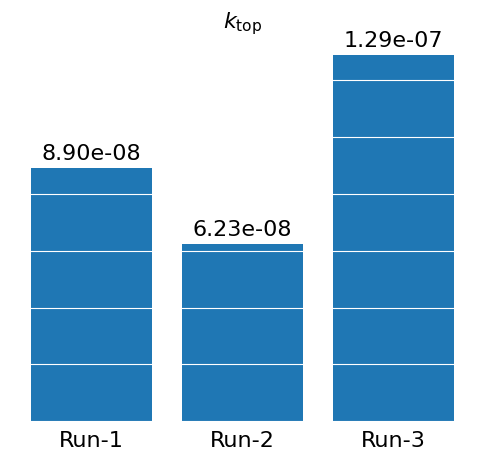

In [ ]:
import requests

url = "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-1/refs/tags/v0.5/data/processed_data.json"
response = requests.get(url)
data_run_1 = response.json()

url = "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-2/refs/tags/v0.3/data/processed_data.json"
response = requests.get(url)
data_run_2 = response.json()

plt.figure(figsize=(6, 5))
bars = plt.bar(
    [0, 1, 2],
    [data_run_1["k_top"]["value"], data_run_2["k_top"]["value"], k_top.magnitude],
    tick_label=["Run-1", "Run-2", "Run-3"],
)

plt.bar_label(bars, fontsize=16, fmt="%.2e", padding=3)
plt.title(r"$k_\mathrm{top}$", weight="bold", fontsize=16)
plt.ylabel("")
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels
plt.gca().tick_params(axis="both", which="both", left=False, bottom=False, labelsize=16)
plt.gca().set_axisbelow(False)
plt.grid(axis="y", alpha=1, color="white", zorder=-10)
plt.show()

In [ ]:
def model_from_json(json_data: dict) -> Model:
    """
    Create a model from JSON data.
    """
    # Extract the relevant data from the JSON
    k_top = json_data["k_top"]["value"] * ureg(json_data["k_top"]["unit"])
    k_wall = json_data["k_wall"]["value"] * ureg(json_data["k_wall"]["unit"])
    neutron_rate = json_data["neutron_rate_used_in_model"]["value"] * ureg(
        json_data["neutron_rate_used_in_model"]["unit"]
    )
    irradiations = [
        (
            irr["start_time"]["value"] * ureg(irr["start_time"]["unit"]),
            irr["stop_time"]["value"] * ureg(irr["stop_time"]["unit"]),
        )
        for irr in json_data["irradiations"]
    ]

    # Create a new model instance with the extracted parameters
    model = Model(
        radius=json_data["modelled_baby_radius"]["value"]
        * ureg(json_data["modelled_baby_radius"]["unit"]),
        height=json_data["modelled_baby_height"]["value"]
        * ureg(json_data["modelled_baby_height"]["unit"]),
        TBR=json_data["TBR_used_in_model"]["value"]
        * ureg(json_data["TBR_used_in_model"]["unit"]),
        k_top=k_top,
        k_wall=k_wall,
        neutron_rate=neutron_rate,
        irradiations=irradiations,
    )

    return model

/home/codespace/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


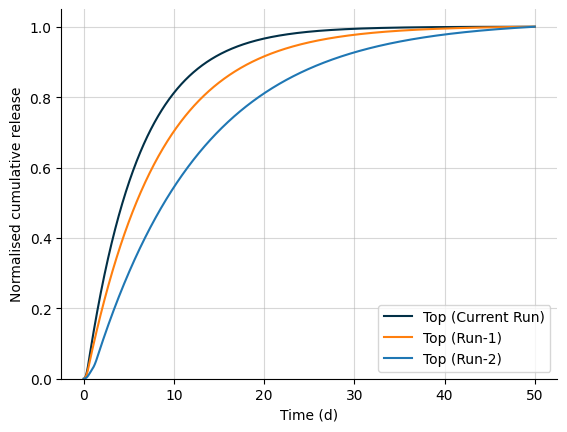

In [ ]:
from libra_toolbox.tritium.plotting import COLLECTION_VOLUME, LSC_SAMPLE_VOLUME

def plot_normalised_integrated_top(model, **kwargs):
    integrated_top = quantity_to_activity(model.integrated_release_top()).to(ureg.Bq)
    sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME

    normalised_top = sample_activity_top / sample_activity_top[-1]

    l = plt.plot(model.times.to(ureg.day), normalised_top, **kwargs)
    return l

plt.figure()

# current run
l = plot_normalised_integrated_top(
    baby_model, color="#023047", label="Top (Current Run)"
)

# run 1
model_run_1 = model_from_json(data_run_1)
model_run_1.run(50 * ureg.day)

l = plot_normalised_integrated_top(model_run_1, color="tab:orange", label="Top (Run-1)")

# run 2
model_run_2 = model_from_json(data_run_2)
model_run_2.run(50 * ureg.day)

l = plot_normalised_integrated_top(model_run_2, color="tab:blue", label="Top (Run-2)")

plt.ylim(bottom=0)
plt.grid(alpha=0.5)
plt.legend()

plt.ylabel("Normalised cumulative release")
plt.xlabel(f"Time ({plt.gca().xaxis.get_units():~P})")

plt.show()
